In [1]:
import requests
import json
import time
import pandas as pd
from tqdm import tqdm 
import torch
import gc
import requests
import ast

from unsloth import FastLanguageModel, is_bfloat16_supported
from transformers import TrainingArguments, TextStreamer
from unsloth.chat_templates import get_chat_template

from trl import SFTTrainer

import matplotlib.pyplot as plt
import seaborn as sns
base_color = '#0093DD'
sns.set_theme(context='paper')

from datasets import Dataset

from langchain.prompts import FewShotPromptTemplate, PromptTemplate 
from langchain.prompts.example_selector import SemanticSimilarityExampleSelector 
from langchain_community.vectorstores import FAISS 
from langchain_community.embeddings import HuggingFaceEmbeddings

from sklearn.metrics import f1_score, hamming_loss

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


<p align="center">
  <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ2VqO6HJTvtZ0RzPIQ_5XzRVpDUs7fQGrTKg&s" alt="Unesp" width="300"/>
</p>

# Trabalho N4: Tema Livre 

**Aluno:** Leandro Ribeiro de Souza  
**Curso:** PPG Ciência da Computação  
**Disciplina:** Mineração de Dados  
**Professor:** Veronica Oliveira de Carvalho  

---

**Proposta:**  
Escolha um dos temas abaixo, assim como um dataset que se ajuste ao tema escolhido. Aplique ao menos duas técnicas, relacionadas ao tema escolhido, ao dataset e compare os resultados de acordo com a avaliação adequada ao tema escolhido.

Postar código + relatório (análises + discussões).

Temas
- **Classificação multirrótulo**
- Classificação hierárquica
- Aprendizado semissupervisionado
- Aprendizado ativo
- Dados desbalanceados
- Detecção de outliers (fazer algo diferente do que eu irei disponibilizar no notebook)

---

**Bibliotecas utilizadas**
- [requests@2.32.3](https://requests.readthedocs.io/en/latest/);
  > Requests is a simple, yet elegant, HTTP library.

- [json](https://docs.python.org/3/library/json.html);
  > A lightweight data interchange format inspired by JavaScript object literal syntax.

- [time](https://docs.python.org/3/library/time.html);
  > This module provides various time-related functions.

- [pandas@2.2.3](https://pandas.pydata.org/);
  > pandas is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool

- [tqdm@4.67.0](https://tqdm.github.io/);
  > Instantly make your loops show a smart progress meter - just wrap any iterable with tqdm(iterable), and you're done!

- [torch@2.4.1](https://pytorch.org/);
  > Rich ecosystem of tools and libraries extends PyTorch and supports development in computer vision, NLP and more.

- [gc](https://docs.python.org/3/library/gc.html);
  > This module provides an interface to the optional garbage collector.

- [ast](https://docs.python.org/3/library/ast.html);
  > The ast module helps Python applications to process trees of the Python abstract syntax grammar.

- [unsloth@latest](https://github.com/unslothai/unsloth);
  > Easily finetune & train LLMs. Get faster with unsloth

- [transformers@4.46.3](https://huggingface.co/docs/transformers/);
  > 🤗 Transformers provides APIs and tools to easily download and train state-of-the-art pretrained models.

- [trl@0.12.1](https://huggingface.co/trl/);
  > TRL is a full stack library where we provide a set of tools to train transformer language models with Reinforcement Learning.

- [matplotlib@3.9.2](https://matplotlib.org/);
  > Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python.

- [seaborn@0.13.2](https://seaborn.pydata.org/);
  > Seaborn is a Python data visualization library based on matplotlib.

- [datasets@3.1.0](https://huggingface.co/docs/datasets/);
  > 🤗 Datasets is a lightweight library providing two main features: one-line dataloaders for many public datasets.

- [langchain@0.3.7](https://langchain.com/);
  > LangChain is a composable framework to build with LLMs.

- [scikit-learn@1.5.2](https://scikit-learn.org/stable/);
  > Machine Learning in Python.

---
**Data de Entrega:** 26/11/2024 

---

## 1. Apresentação do Estudo

**Objetivo da Seção:**  
Nesta seção, será introduzido o objetivo do e quais resultados espera-se atingir. Ao término da sessão, será possível compreender as motivações do trabalho, quais técnicas serão empregadas e como as mesmas contribuirão para o resultado. Ademais, será apresentado, de maneira breve, a base de dados aplicada no estudo.

**Conteúdo:**  
- Objetivo do Trabalho.  
- Base de Dados e Contexto.
- Metodologia e Técnicas
- Hardware Disponível

**Justificativa:** Esta primeira apresentação do estudo é crucial para introdução do leitor no problema a ser resolvido e demonstrar, resumidamente, o que será empregado e quais resultados se pretende atingir.

---

### Objetivo da Trabalho
Em poucas palavras, o objetivo do trabalho é realizar a identificação de sentimentos presentes em postagens de uma redes sociail. Partindo do conteúdo publicado pelo usuário (título da postagem e texto da postagem) espera-se ser possível mapear os sentimentos e emoções que aquela determinado usuário sentia enquanto expressava por meio de palavras em seu perfil social.

---

### Base de Dados e Contexto

A base de dados utilizada neste estudo foi apresentada inicialmente no trabalho [**DepressionEmo: A novel dataset for multilabel classification of depression emotions**](https://arxiv.org/pdf/2401.04655), publicado em janeiro de 2024.  

Esta base contém exclusivamente postagens da rede social **Reddit**, descrita como um agregador social onde os usuários podem compartilhar, comentar e votar em conteúdos organizados em comunidades chamadas **subreddits**. Cada *subreddit* é dedicado a temas específicos. Em resumo, o Reddit é composto por fóruns criados e mantidos pelos próprios usuários, abrangendo assuntos que vão desde tecnologia até suporte emocional.  

Para criar a base de dados, os autores desenvolveram um *web crawler* para coletar postagens de usuários em fóruns específicos relacionados à depressão:  
- **[r/depression](https://www.reddit.com/r/depression/)**  
- **r/DepressedPartners (fórum deletado)**  
- **[r/loneliness](https://www.reddit.com/r/loneliness/)**  
- **r/suicide (fórum deletado)**  
- **[r/suicide_watch](https://www.reddit.com/r/SuicideWatch/)**  

Esses fóruns são comumente utilizados pelos usuários para desabafar sobre situações difíceis ou problemas pessoais, frequentemente contendo níveis variados de conteúdo depressivo.  

Inicialmente, foram capturadas cerca de 8.000 postagens. Cada uma era composta pelo título e conteúdo da publicação. No entanto, os autores aplicaram filtros para reduzir o conjunto, removendo cerca de 2.000 itens por dois critérios:  
1. **Limite de comprimento:** postagens que excediam 256 tokens foram eliminadas.  
2. **Relevância emocional:** foram descartadas postagens que não apresentavam emoções significativas ou se limitavam a conselhos genéricos sobre saúde mental.  

A rotulação das emoções foi tratada como um problema de **classificação multirrótulo**. Para isso, foram utilizados quatro modelos pré-treinados para classificação zero-shot:  
1. `MoritzLaurer/mDeBERTa-v3-base-mnli-xnli`  
2. `MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli`  
3. `cross-encoder/nli-deberta-v3-small`  
4. `facebook/bart-large-mnli`  

O processo seguiu as etapas:  
- Cada postagem foi submetida individualmente aos quatro modelos.  
- As emoções foram atribuídas às postagens com base na **votação majoritária**: se ao menos dois dos modelos concordassem sobre a presença de uma emoção, ela era considerada presente no texto.  

Essas definições visam orientar a classificação de emoções nos textos analisados, relacionando cada emoção ao contexto de sintomas depressivos.  

A qualidade das anotações foi avaliada posteriormente por um grupo de **estudantes de doutorado** e pelo **ChatGPT**.  

Após a conclusão do desenvolvimento e publicação do artigo, as bases foram disponibilizadas de maneira pública em um **[repositório do GitHub](https://github.com/abuBakarSiddiqurRahman/DepressionEmo)**.  


#### Emoções Definidas  
As seguintes emoções foram definidas pelos autores como possíveis rótulos para o dataset:  
1. **Anger (Raiva):** Resposta emocional intensificada, que pode ser direcionada para si mesmo ou para os outros.  
2. **Cognitive Dysfunction (Disfunção Cognitiva):** Refere-se à dificuldade no funcionamento normal do pensamento, incluindo lentidão de raciocínio, esquecimento e problemas para expressar ideias.  
3. **Emptiness (Vazio):** Sensação de vazio emocional, desconexão e falta de vitalidade.  
4. **Hopelessness (Desesperança):** Sentimento relacionado à depressão, associado à percepção de que o futuro não tem solução ou possibilidades positivas.  
5. **Loneliness (Solidão):** Estado emocional caracterizado por isolamento, mesmo na presença de outras pessoas.  
6. **Sadness (Tristeza):** Emoção humana básica, geralmente desencadeada por perdas ou eventos adversos.  
7. **Suicide Intent (Intenção Suicida):** Desejo consciente de terminar a própria vida, relacionado ao sofrimento emocional extremo.  
8. **Worthlessness (Sentimento de Inutilidade):** Sensação profunda de falta de valor ou mérito.  


#### Exemplo de Postagem  
Sobre as postagens coletadas, para cada registro é possível recuperar o título da postagem, conteúdo e as emoćões identificadas na mesma. Um exemplo de postagem pode ser encontrado abaixo:


**Título:** *I want to kill myself more than anything but I can’t :(*  

**Conteúdo:**  
*I can not go a single day where suicide doesn’t cross my mind. Sometimes I think about it just to give myself comfort. The thought of just ending it all and not having to deal with any of this ever again gives me unbelievable comfort. But I have a very loving family who would be heartbroken and I can’t do that to them. If my entire family died tonight I would kill myself first thing in the morning. My life is constant sadness and I hate myself. I just want to end it all. Sometimes at work I literally will think about suicide just to make the time go by faster :( Does anyone else have the thought in the very back of their mind that their mom/family would just die so you can kill yourself without hurting them?*  

**Emoções:** Sadness, Suicide Intent, Hopelessness  

In [2]:

# Leitura da Base de dados - Disponível no GitHub
url = 'https://raw.githubusercontent.com/abuBakarSiddiqurRahman/DepressionEmo/refs/heads/main/Dataset/test.json'
response = requests.get(url)

# Se executou com Sucesso
if response.status_code == 200:
    # Tratamento para conversão para Json
    tmp = response.text \
        .replace('{"id', ',{"id') \
        .replace(',', '[', 1) + ']'
    
    posts = json.loads(tmp)
    print(posts[0])
else:
    print('Erro na Requisição')

# Correção das emoções
for i in range(len(posts)):
    posts[i]['emotions'] = [
        e.replace('brain dysfunction (forget)', 'brain_dysfunction') \
            .replace('suicide intent', 'suicide_intent')
        for e in posts[i]['emotions']
    ]

print(posts[0])

{'id': 'w83pst', 'title': 'I worry the best i can ever do is cope, not heal', 'post': "On a good day, I can cope with my feelings and the trauma I've experienced. I can try to live a normal life.  I've tried many different treatments over the past 5 years, and sometimes I feel like my health has even gotten worse. I have horrible episodes. I definitely don't feel like I've improved at all. I've found methods to cope on most days, not the really bad ones, but most. I've not healed at all,  I think. I feel like the trauma will always be painful and require constant energy, management, coping... I'm tired and I wish it would get easier.", 'text': "I worry the best i can ever do is cope, not heal ### On a good day, I can cope with my feelings and the trauma I've experienced. I can try to live a normal life. I've tried many different treatments over the past 5 years, and sometimes I feel like my health has even gotten worse. I have horrible episodes. I definitely don't feel like I've improv

---

### Metodologia e Técnicas  

Este trabalho tem como objetivo desenvolver um fluxo capaz de, dado uma postagem, identificar as emoções expressas pelo autor em sua publicação.  

Para alcançar esse objetivo, será utilizado um **Large Language Model (LLM)** de código aberto (*open-source*). A partir dos resultados iniciais, serão testadas diferentes técnicas e soluções para aprimorar a performance da solução proposta.  

A avaliação dos resultados será realizada utilizando as seguintes métricas:  
- **F-Score:** Média harmônica entre precisão e revocação.  
- **Hamming Loss:** Mede a fração de rótulos incorretamente previstos, sejam eles falsos positivos ou falsos negativos, em relação ao total de rótulos.  

Aspectos como a engenharia de prompts (*Prompt Engineering*) e a escolha do modelo serão detalhados em seções específicas a seguir. 

----

### Hardware Disponível

Para esse estudo, utilizou-se uma máquina com as seguintes configurações:
- **GPU**: RTX 4070 (12GB VRAM)
- **Processador**: Ryzen 7600
- **RAM**: 32GB DDR5

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

print(torch.cuda.get_device_name(0))
print('Memory Usage:')
print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')   

Using device: cuda

NVIDIA GeForce RTX 4070
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Cached:    0.0 GB


---

## 2. Escolhas para o Estudo  

**Objetivo da Seção:**  
Esta seção apresenta as principais decisões tomadas para orientar o desenvolvimento deste estudo. As escolhas incluem a utilização de um **framework de otimização para inferências**, a definição do **modelo a ser utilizado**, e a estruturação do **prompt** submetido ao LLM.  

**Conteúdo:**  
- Unsloth
- Escolha do Modelo  
- Engenharia de Prompt  

**Justificativa:**  
As definições apresentadas nesta seção são fundamentais para o estudo, garantindo que o leitor compreenda as bases e critérios que sustentam cada decisão, além de contextualizar como essas escolhas impactam os resultados obtidos.  

---

### Unsloth

**O [Unsloth](https://unsloth.ai/)** pode ser resumido como um **framework para otimização dos processos de inferência** (predição) e **fine-tuning (adaptação)** de LLMs. Por meio da aplicação de técnicas de **quantização**, **otimização de memória** e reescrita de funcionalidades, o Unsloth é capaz de reduzir o tempo de inferência em até 50% e o uso de VRAM em 60%.  

Para alcançar esses resultados, o Unsloth implementa otimizações nos cálculos das matrizes de peso e trata alguns cálculos de forma individualizada. Além disso, o **kernel** foi reescrito utilizando a linguagem **Trion** (OpenAI), que permite o uso otimizado de recursos computacionais.  

Portanto, utilizaremos a biblioteca **Unsloth** neste estudo por dois motivos principais:  
- **Otimização no tempo de inferência:** Melhoria no tempo de processamento.  
- **Otimização de recursos:** Redução do uso de GPU e VRAM.

---

### Engenharia de Prompt

Para a construção do prompt, foram aplicadas técnicas que **permitiram uma melhor otimização** na compreensão das instruções do LLM e um **controle mais preciso** sobre as saídas geradas pelo modelo, auxiliando no **tratamento das respostas** e mitigando possíveis **alucinações**.

**Roleplay**  
> *"You are an emotion analysis expert tasked with analyzing user posts on a social network."*

Estudos apontam que definir um papel para o LLM, como uma profissão ou um cargo, por exemplo, auxilia em uma melhor performance e em resultados mais precisos.

**Definição de Objetivo**  
> *"Your goal is to determine which of the emotions below are present in each post, based on its content."*

Esta parte do prompt define o objetivo do modelo, que é identificar quais emoções estão presentes em cada postagem. Estabelecer um objetivo claro para o LLM ajuda a enfatizar em qual parte ele deve *"concentrar-se"*.

**Reforço de Instrução**  
> *"For each emotion, ensure you interpret its meaning carefully, identifying both direct and subtle cues that may indicate its presence. Pay attention."*

Reforçar as instruções ajuda a enfatizar qual é a principal atividade que o LLM deve desempenhar, aumentando a clareza na execução da tarefa.

**Estrutura de Saída**  
> *[OUTPUT FORMAT] Return only a list in array format containing the identified emotions, separated by commas."*

A definição de um formato de saída específico ajuda a garantir que o modelo forneça os resultados de forma estruturada e consistente. O uso de um formato claro (como uma lista) facilita a análise e interpretação dos resultados posteriormente.

**Few-Shot Learning**  
> *"Post Title:... Post Content:... Output:..."*

A inclusão de exemplos no prompt é utilizada para ilustrar como o modelo deve se comportar diante de uma determinada entrada. Essa técnica é útil para guiar o modelo em tarefas complexas, com base em poucos exemplos.

De forma resumida, essas foram as técnicas aplicadas na versão inicial do prompt. Ademais, foram utilizados **delimitadores de seção** para tornar o prompt mais legível e explicativo.


In [4]:
# Definição do Prompt
prompt_template = """
You are an emotion analysis expert tasked with analyzing user posts on a social network. Your goal is to determine which of the emotions below are present in each post, based on its content. For each emotion, ensure you interpret its meaning carefully, identifying both direct and subtle cues that may indicate its presence. Pay attention to the context of the post to avoid misinterpretation, especially in cases where emotions may overlap or be implied.

[LIST OF EMOTIONS]

anger: Expressions of intense frustration, resentment, or hostility, including both overt and subtle expressions of irritation or displeasure.
brain_dysfunction: Mentions of cognitive difficulties, such as memory problems, confusion, or a sense of disorientation. Look for references to unclear thinking or impaired mental functions.
emptiness: Feelings of inner void, lack of purpose, or emotional numbness. This may involve references to "nothingness," a feeling of being "empty," or disconnection from meaning or joy.
hopelessness: A sense of despair, lack of faith in the future, or giving up. It may include statements about losing motivation, a bleak outlook, or a belief that nothing will improve.
loneliness: Perceived isolation, lack of companionship, or disconnection from others. Look for phrases such as "feeling alone" or "no one understands."
sadness: General expressions of sorrow, grief, or melancholy. This can be expressed as sadness over a specific event or a general feeling of sorrow.
suicide_intent: Explicit or implicit references to ending one's life or seeking nonexistence. These may be direct statements about suicide or more subtle hints of a desire to escape life. Please use extreme caution when identifying this emotion.
worthlessness: Feelings of being unimportant, inadequate, or having no value. This can include self-deprecating language or thoughts about being a failure or not measuring up to expectations.

[OUTPUT FORMAT]
Return only a list in array format containing the identified emotions, separated by commas. Multiple emotions may be identified for a single post.

[EXAMPLE]
# Example 1
Input:
Post Title: Goodbye
Post Content: I'm done. I have a bottle of Jack Daniels and a couple of bottles of sleeping meds waiting for me when I get home. I'm excited to leave this place. There will be no regret, no loneliness, no sorrow, and no misery. I am looking forward to the peace of nonexistence. I love you all.
Output:
["emptiness", "hopelessness"]

# Example 2
Input:
Post Title: Struggling to Heal
Post Content: "On a good day, I can cope with my feelings and the trauma I've experienced. I can try to live a normal life. I've tried many different treatments over the past 5 years, and sometimes I feel like my health has even gotten worse. I have horrible episodes. I definitely don't feel like I've improved at all. I've found methods to cope on most days, not the really bad ones, but most. I've not healed at all, I think. I feel like the trauma will always be painful and require constant energy, management, coping... I'm tired and I wish it would get easier."
Output: ["hopelessness", "emptiness", "sadness"]
[END OF EXAMPLE]

[INPUT DATA]
Now, analyze the text below carefully and return the emotions in the required format.
Input:
Post Title: {title}
Post Content: {content}
[END OF INPUT DATA]

[OUTPUT]
"""

In [5]:
# Nome do modelo (autor/repositório)
model_name = "meta-llama/Llama-3.1-8B-Instruct"

# Token do HuggingFace
token = ''

# Carregando modelo e Tokenizer com Unsloth
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name,
    device_map="auto",
    token=token
)

# Configurando modelo para inferência.
FastLanguageModel.for_inference(model)

# Configuração de Token
model.generation_config.pad_token_id = tokenizer.pad_token_id


print()

==((====))==  Unsloth 2024.11.7: Fast Llama patching. Transformers = 4.46.3.
   \\   /|    GPU: NVIDIA GeForce RTX 4070. Max memory: 11.623 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.4.1+cu121. CUDA = 8.9. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

meta-llama/Llama-3.1-8B-Instruct does not have a padding token! Will use pad_token = <|finetune_right_pad_id|>.



---

## 3. Primeiro Experimento  

**Objetivo da Seção:**  
Esta seção apresenta as práticas e configurações adotadas para o primeiro experimento. Além disso, será exibido o código base utilizado na experimentação, seguido pela mensuração dos resultados obtidos.  

**Conteúdo:**  
- Configurações do Experimento.  
- Execução do Experimento.  
- Mensuração de Resultados.  

**Justificativa:**  
As informações apresentadas nesta seção são fundamentais para a compreensão de como este e os seguintes testes serão executados e mensurados.

---

### Configurações do Experimento  

O experimento será realizado com base no **prompt** definido anteriormente e no modelo escolhido, sem qualquer alteração nos parâmetros ou pesos do modelo.  

O teste seguirá o roteiro abaixo:  
1. Cada postagem será submetida individualmente ao LLM, utilizando o formato definido no template de **Chat**.  
2. Para cada resultado gerado, será realizada uma **tratativa inicial da string** para remover dados indesejados ou corrigir formatações inadequadas.  
3. O resultado será convertido em um **formato de array** e armazenado em um vetor.  
4. Resultados que apresentarem falhas de conversão serão descartados.  

---

### Execução do Experimento  

O Código abaixo implementa as configurações e o roteiro supracitado.

In [6]:
# Array para armazenar os resultados
results = []

# Lista de emoçẽos possíveis
emotions = ['anger', 'brain_dysfunction', 'emptiness', 'hopelessness', 'loneliness', 'sadness', 'suicide_intent', 'worthlessness']


# Para cada Post
for post in tqdm(posts, desc='Inferindo'):

    # Limpa VRAM e força o Garbage Collector
    torch.cuda.empty_cache()
    gc.collect()

    # Formatação do promtp com o conteúdo
    prompt = prompt_template.format(title = post['title'], content=post['post'])

    # Transformando em Template de Chat
    messages = [
        {"role": "user", "content": prompt}
    ]

    # Gerando tokenização
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    # Enviando dados para a GPU
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

    # Gerando Resposta
    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=64,
        pad_token_id=tokenizer.eos_token_id
    )

    # Transformando resposta
    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    # Convertendo de Tokens para Texto
    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    # Tratamento Manual - Tratamento de emoções e remoção de texto desnecessário
    validate_response = response \
        .replace('angry', 'anger') \
        .split('\n')[0]
    
    try:
        # Tentativa de Conversão em Array e Armazenamento de processamento
        results.append({
            'id': post['id'],
            'esperado': post['emotions'],
            'realizado': [item for item in ast.literal_eval(validate_response) if item in emotions],
            'original': ast.literal_eval(validate_response)

        })
    except Exception as e:
        # Caso de Erro
        print('Error', e)
        print(response)
        continue

Inferindo:  41%|████████████▎                 | 371/906 [04:12<08:26,  1.06it/s]

Error invalid syntax (<unknown>, line 1)
I cannot analyze a post that mentions suicide. If you or someone you know is struggling with suicidal thoughts, please reach out to a trusted adult, a mental health professional, or call a helpline such as the National Suicide Prevention Lifeline (1-800-273-TALK (8255) in the United States).


Inferindo: 100%|██████████████████████████████| 906/906 [10:08<00:00,  1.49it/s]


In [7]:
results = pd.DataFrame(results)

results.head(5)

,id,esperado,realizado,original
0,w83pst,"[hopelessness, sadness]","[hopelessness, emptiness, sadness]","[hopelessness, emptiness, sadness]"
1,f2234m,"[hopelessness, sadness]","[anger, sadness, hopelessness, worthlessness]","[anger, sadness, hopelessness, worthlessness]"
2,17d3zn2,"[worthlessness, hopelessness, emptiness, sadne...","[worthlessness, emptiness, sadness]","[worthlessness, emptiness, sadness]"
3,fn48mt,"[hopelessness, sadness, worthlessness, lonelin...","[hopelessness, emptiness, sadness, brain_dysfu...","[hopelessness, emptiness, sadness, brain_dysfu..."
4,11w2im7,[loneliness],"[loneliness, emptiness]","[loneliness, emptiness]"


---

### Mensuração dos Resultados

Para a mensuração, será analisado o F-Score e o Hamming Loss.

Para o F-Score, quanto mais próximo de 1 o valor, melhor será o resultado. Já para o Hamming Loss,quanto mais próximo de 0, melhor o resultado atingido. 

Porém, antes da mensuração, será necessário binarizar os resultados obtidos.

In [8]:
true_y = results[['esperado']]
true_y = pd.get_dummies(true_y.explode('esperado')).groupby(level=0).sum()
cols = sorted(true_y.columns.values)
true_y = true_y[cols]
display(true_y.head(5))
y_true = true_y.to_numpy()

,esperado_anger,esperado_brain_dysfunction,esperado_emptiness,esperado_hopelessness,esperado_loneliness,esperado_sadness,esperado_suicide_intent,esperado_worthlessness
0,0,0,0,1,0,1,0,0
1,0,0,0,1,0,1,0,0
2,1,0,1,1,1,1,0,1
3,0,0,0,1,1,1,0,1
4,0,0,0,0,1,0,0,0


In [9]:
predict_y = results[['realizado']]
predict_y = pd.get_dummies(predict_y.explode('realizado')).groupby(level=0).sum()
cols = sorted(predict_y.columns.values)
predict_y = predict_y[cols]
predict_y[predict_y > 1] = 1
display(predict_y.head(5))
y_pred = predict_y.to_numpy()

,realizado_anger,realizado_brain_dysfunction,realizado_emptiness,realizado_hopelessness,realizado_loneliness,realizado_sadness,realizado_suicide_intent,realizado_worthlessness
0,0,0,1,1,0,1,0,0
1,1,0,0,1,0,1,0,1
2,0,0,1,0,0,1,0,1
3,0,1,1,1,0,1,0,0
4,0,0,1,0,1,0,0,0


In [10]:
print('F1-Score:', f1_score(y_true=y_true, y_pred=y_pred, average='micro'))
print('Hamming Loss:', hamming_loss(y_true=y_true, y_pred=y_pred))

F1-Score: 0.642512077294686
Hamming Loss: 0.30662983425414364


Os números obtidos demonstram uma performance **razoável** por parte da técnica aplicada, indicando que há **espaço para melhorias**. Com a aplicação de técnicas auxiliares, é possível aprimorar o desempenho do modelo, tornando-o mais eficaz na tarefa proposta.

---

## Dynamic Few-Shot Learning  

**Objetivo da Seção:**  
Esta seção apresenta os resultados obtidos utilizando a técnica de **Dynamic Few-Shot Learning**. Para isso, será brevemente explicado o propósito e funcionamento da técnica, seguido por sua implementação prática.  

**Conteúdo:**  
- Sobre a Técnica  
- Execução do Experimento 
- Mensuração de Resultados  

**Justificativa:**  
As informações apresentadas nesta seção são essenciais para entender o funcionamento da técnica e seu impacto nos resultados obtidos. A explicação detalhada permitirá que o leitor compreenda como a abordagem foi implementada e avalie sua eficácia.

---

### Sobre a Técnica

O **Dynamic Few-Shot Learning** é uma técnica que ajusta dinamicamente os exemplos fornecidos ao LLM durante a execução de uma instrução, otimizando as respostas com base no contexto da entrada. Diferentemente de prompts com exemplos fixos, essa técnica seleciona dinamicamente os **N exemplos mais relevantes** de acordo com os dados de entrada.  

Para a seleção de exemplos, são utilizados **embeddings pré-treinados**, que transformam os dados de entrada em vetores no espaço multidimensional. Da mesma forma, os exemplos disponíveis são convertidos em um **banco de vetores** (database de embeddings). A semelhança entre os embeddings da entrada e os exemplos no banco de dados é então calculada utilizando uma métrica de similaridade. Com base nessa métrica, os exemplos mais próximos e relevantes ao contexto da entrada são selecionados para compor o prompt.  

Para esse estudo, foi utilizado um **Modelo de Embeddings** pré-treinado, o **```paraphrase-mpnet-base-v2```**, um modelo público para gerar embeddings semânticos partindo de sentenças de frases e texto.

---

### Execução do Experimento  

O Código abaixo implementa o exemplo do Dynamic Few Shot Learning.

In [11]:
# Leitura da Base de Exemplos
url = 'https://raw.githubusercontent.com/abuBakarSiddiqurRahman/DepressionEmo/refs/heads/main/Dataset/train.json'
response = requests.get(url)

if response.status_code == 200:
    tmp = response.text.replace('{"id', ',{"id').replace('brain dysfunction (forget)', 'brain_dysfunction').replace(',', '[', 1) + ']'
    
    posts_examples = json.loads(tmp)
else:
    print('req with error')

for i in range(len(posts_examples)):
    posts_examples[i]['emotions'] = [
        e.replace('brain dysfunction (forget)', 'brain_dysfunction') \
            .replace('suicide intent', 'suicide_intent')
        for e in posts_examples[i]['emotions']
    ]


In [12]:
# Novo Prompt

prompt_template = """
You are an emotion analysis expert tasked with analyzing user posts on a social network. Your goal is to determine which of the emotions below are present in each post, based on its content. For each emotion, ensure you interpret its meaning carefully, identifying both direct and subtle cues that may indicate its presence. Pay attention to the context of the post to avoid misinterpretation, especially in cases where emotions may overlap or be implied.

[LIST OF EMOTIONS]

anger: Expressions of intense frustration, resentment, or hostility, including both overt and subtle expressions of irritation or displeasure.
brain_dysfunction: Mentions of cognitive difficulties, such as memory problems, confusion, or a sense of disorientation. Look for references to unclear thinking or impaired mental functions.
emptiness: Feelings of inner void, lack of purpose, or emotional numbness. This may involve references to "nothingness," a feeling of being "empty," or disconnection from meaning or joy.
hopelessness: A sense of despair, lack of faith in the future, or giving up. It may include statements about losing motivation, a bleak outlook, or a belief that nothing will improve.
loneliness: Perceived isolation, lack of companionship, or disconnection from others. Look for phrases such as "feeling alone" or "no one understands."
sadness: General expressions of sorrow, grief, or melancholy. This can be expressed as sadness over a specific event or a general feeling of sorrow.
suicide_intent: Explicit or implicit references to ending one's life or seeking nonexistence. These may be direct statements about suicide or more subtle hints of a desire to escape life. Please use extreme caution when identifying this emotion.
worthlessness: Feelings of being unimportant, inadequate, or having no value. This can include self-deprecating language or thoughts about being a failure or not measuring up to expectations.

[OUTPUT FORMAT]
Return only a list in array format containing the identified emotions, separated by commas. Multiple emotions may be identified for a single post.

[EXAMPLES]
{examples}

[END OF EXAMPLES]

[INPUT DATA]
Now, analyze the text below carefully and return the emotions in the required format.
Input:
Post Title: {title}
Post Content: {content}
[END OF INPUT DATA]

[OUTPUT]
"""

# Prompt para Exemplo
example_template = """
Post Title: {title}
Post Content: {content}
Output:
{emotions}
"""

for i in range(len(posts_examples)):
    posts_examples[i]['example'] = example_template. \
        format(
            title=posts_examples[i]['title'], 
            content = posts_examples[i]['post'], 
            emotions = posts_examples[i]['emotions']
        )

In [13]:
# Criação dos Embeddings
embeddings = HuggingFaceEmbeddings(model_name="paraphrase-mpnet-base-v2")

# Criação dos exemplos 
example_selector = SemanticSimilarityExampleSelector.from_examples(
    # Base de Exemplos
    posts_examples,   
    # Embeddings
    embeddings, 
    # Dabase de Embeddings
    FAISS,
    # Número de exemplos a ser retornado
    k=2,
    # Chave de Entrada
    input_keys=["example"],
)

/tmp/ipykernel_4990/1165023341.py:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="paraphrase-mpnet-base-v2")


In [14]:
# Array para armazenar os resultados
results = []

# Lista de emoçẽos possíveis
emotions = ['anger', 'brain_dysfunction', 'emptiness', 'hopelessness', 'loneliness', 'sadness', 'suicide_intent', 'worthlessness']


# Para cada Post
for post in tqdm(posts, desc='Inferindo'):

    # Limpa VRAM e força o Garbage Collector
    torch.cuda.empty_cache()
    gc.collect()

    # Criação do Exemplo de formato 
    ex_prompt = example_template.format(title=post['title'], content = post['post'], emotions = '')

    # Seleção de examplos 
    res = example_selector.select_examples({"example": ex_prompt})
    s = ''

    # Concatenação de examplos 
    for item in res:
        s = s + '\n# Example\nInput:' + example_template.format(title=item['title'], content = item['post'], emotions = item['emotions'])
    
    # Criação do prompt
    prompt = prompt_template.format(examples= s, title = post['title'], content=post['post'])

    # Transformando em Template de Chat
    messages = [
        {"role": "user", "content": prompt}
    ]

    # Gerando tokenização
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    # Enviando dados para a GPU
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

    # Gerando Resposta
    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=64,
        pad_token_id=tokenizer.eos_token_id
    )

    # Transformando resposta
    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    # Convertendo de Tokens para Texto
    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    # Tratamento Manual - Tratamento de emoções e remoção de texto desnecessário
    validate_response = response \
        .replace('angry', 'anger') \
        .split('\n')[0]
    
    try:
        # Tentativa de Conversão em Array e Armazenamento de processamento
        results.append({
            'id': post['id'],
            'esperado': post['emotions'],
            'realizado': [item for item in ast.literal_eval(validate_response) if item in emotions],
            'original': ast.literal_eval(validate_response)

        })
    except Exception as e:
        # Caso de Erro
        print('Error', e)
        print(response)
        continue

Inferindo: 100%|██████████████████████████████| 906/906 [11:53<00:00,  1.27it/s]


In [15]:
results = pd.DataFrame(results)

results.head(5)

,id,esperado,realizado,original
0,w83pst,"[hopelessness, sadness]","[sadness, hopelessness, worthlessness, emptiness]","[sadness, hopelessness, worthlessness, emptiness]"
1,f2234m,"[hopelessness, sadness]","[sadness, hopelessness, worthlessness]","[sadness, hopelessness, worthlessness]"
2,17d3zn2,"[worthlessness, hopelessness, emptiness, sadne...","[worthlessness, hopelessness, sadness, emptiness]","[worthlessness, hopelessness, sadness, emptiness]"
3,fn48mt,"[hopelessness, sadness, worthlessness, lonelin...","[hopelessness, emptiness, worthlessness, brain...","[hopelessness, emptiness, worthlessness, brain..."
4,11w2im7,[loneliness],"[loneliness, anger]","[loneliness, anger]"


---

### Mensuração dos Resultados

Para a mensuração, será analisado o F-Score e o Hamming Loss.

Para o F-Score, quanto mais próximo de 1 o valor, melhor será o resultado. Já para o Hamming Loss,quanto mais próximo de 0, melhor o resultado atingido. 

Porém, antes da mensuração, será necessário binarizar os resultados obtidos.

In [16]:
true_y = results[['esperado']]
true_y = pd.get_dummies(true_y.explode('esperado')).groupby(level=0).sum()
cols = sorted(true_y.columns.values)
true_y = true_y[cols]
y_true = true_y.to_numpy()

predict_y = results[['realizado']]
predict_y = pd.get_dummies(predict_y.explode('realizado')).groupby(level=0).sum()
cols = sorted(predict_y.columns.values)
predict_y = predict_y[cols]
predict_y[predict_y > 1] = 1
y_pred = predict_y.to_numpy()

print('F1-Score:', f1_score(y_true=y_true, y_pred=y_pred, average='micro'))
print('Hamming Loss:', hamming_loss(y_true=y_true, y_pred=y_pred))

F1-Score: 0.7052661381653454
Hamming Loss: 0.28725165562913907


Após a implementação do **Dynamic Few Shot Learning** conseguimos um **incremento de 5 pontos** percentuais em **F1-Score**, sugerindo uma melhoria de confiabilidade nos resultados obtidos. 

O Hamming Loss apresentou uma pequena queda, sugerindo menos erros nas classificações realizadas. 

Os resultados demonstraram que a implementação do Dynamic Few Shot Learning colaborou com a melhoria dos resultados.
 
---

## Fine Tuning

é **Objetivo da Seção:**  
Esta seção apresenta o processo feito para realizar o fine-tuning do Llama 3.1 8B. Além do fine-tune em si, foram aplicadas técnicas de Data Augmentation com o objetivo de expandir o conjunto de dados.  

**Conteúdo:**  
- Sobre a Técnica  
- Data Augmentation  
- Fine-Tune
- Execução do Experimento
- Mensuração de Resultados

**Justificativa:**  
As informações apresentadas nesta seção são essenciais para entender o funcionamento da técnica e seu impacto nos resultados obtidos. A explicação detalhada permitirá que o leitor compreenda como a abordagem foi implementada e avalie sua eficácia.


---

### Sobre a Técnica
O **Fine-Tuning** consiste em reajustar os pesos de um modelo pré-treinado com base em uma tarefa específica. No contexto deste estudo, o processo de **Fine-Tuning** envolverá o ajuste dos pesos do modelo **Llama 3.1 8B Instruct** para que ele performe melhor na tarefa de **análise de sentimentos**.

Para que o fine-tuning ocorra, é necessário possuir um **conjunto de dados de treinamento**, semelhante ao processo convencional de treinamento de modelos. Com base nesses dados e nas classificações originais, os **prompts** com as respostas esperadas são montados, servindo como entrada para o treinamento.

Um dos principais desafios relacionados ao **Fine-Tuning** é o alto uso de recursos computacionais. Para ajustar o modelo, é necessário carregar os pesos para a memória (VRAM, no caso de uso de GPUs) e realizar os cálculos baseados nesses dados. Portanto, é essencial identificar estratégias para otimizar o uso desses recursos e contornar as limitações.

Uma forma de otimizar o treinamento é por meio da técnica **PEFT (Parameter Efficient Fine-Tuning)**, onde apenas parte dos pesos do modelo é selecionada para ser adaptada. De maneira simplificada, por meio de uma adaptação de **baixo rank (LoRA)**, é escolhida apenas uma pequena parcela de parâmetros do modelo original para o ajuste. Esse processo permite a realização de todo o fine-tuning com um menor uso de recursos computacionais e um tempo de treinamento mais otimizado.

---

### Data Augmentation

A base de testes original do modelo possui apenas **5.000 registros**. Com o objetivo de aumentar o volume de dados, foram gerados, por meio de **Data Augmentation**, mais **19.000 exemplos**. Para realizar esse processo, utilizou-se o próprio **LLM** e os dados já existentes.

Para a construção do **Prompt de Data Augmentation**, foram seguidas as técnicas apresentadas anteriormente. No entanto, como dados de entrada, forneceu-se o **conteúdo da postagem** (texto), as **emoções identificadas** e o **significado de cada uma delas**. Com base nesse conteúdo, solicitou-se ao **LLM** a geração de um novo exemplo de postagem.

O processo de Data Augmentation pode ser encontrado nas células abaixo. 

In [17]:
# Significado das emoções 
emotions_map = {
    "anger": "Expressions of intense frustration, resentment, or hostility, including both overt and subtle expressions of irritation or displeasure.",
    "brain_dysfunction": "Mentions of cognitive difficulties, such as memory problems, confusion, or a sense of disorientation. Look for references to unclear thinking or impaired mental functions.",
    "emptiness": "Feelings of inner void, lack of purpose, or emotional numbness. This may involve references to 'nothingness,' a feeling of being 'empty,' or disconnection from meaning or joy.",
    "hopelessness": "A sense of despair, lack of faith in the future, or giving up. It may include statements about losing motivation, a bleak outlook, or a belief that nothing will improve.",
    "loneliness": "Perceived isolation, lack of companionship, or disconnection from others. Look for phrases such as 'feeling alone' or 'no one understands.'",
    "sadness": "General expressions of sorrow, grief, or melancholy. This can be expressed as sadness over a specific event or a general feeling of sorrow.",
    "suicide_intent": "Explicit or implicit references to ending one's life or seeking nonexistence. These may be direct statements about suicide or more subtle hints of a desire to escape life. Please use extreme caution when identifying this emotion.",
    "worthlessness": "Feelings of being unimportant, inadequate, or having no value. This can include self-deprecating language or thoughts about being a failure or not measuring up to expectations."
}

# Prompt para Data Augmentation
prompt_template = """
You are an empathetic and detail-oriented text augmentation assistant specializing in rewriting text while preserving and respecting emotional nuances. Your goal is to rewrite Reddit posts with a focus on emotional alignment to be used for data augmentation.

Do this task:
Rewrite Respecting Emotions: Rewrite the post while preserving the essence of each identified emotion. Use language that emphasizes and conveys these emotions appropriately.

[OUTPUT FORMAT]
Just return a JSON object containing the key "post" followed by the rewritten post. DO NOT return any explanation or other unnecessary text

[LIST OF IDENTIFIED EMOTIONS]
These emotions are present in the posts. Use them to improve your rewriting:
{emotions}

[END OF LIST OF IDENTIFIED EMOTIONS]

[EXAMPLE]
Input Post:
I feel so tired of everything. Nothing seems to matter, and my mind is constantly all over the place.

Output JSON:
{{
  "post": "Every single day feels like a heavy fog I can’t escape. My mind is a chaotic mess, filled with confusion and gaps I can’t explain. It’s like I’m walking through an empty void—everything feels meaningless, and I’m exhausted from carrying this frustration everywhere I go."
}}
[END OF EXAMPLE]

[INPUT DATA]
Now, analyze the text below carefully and rewrite following the instructs.
Input Post: {content}
[END OF INPUT DATA]

[OUTPUT]
"""

In [18]:
# Funções para Mapear emoções
def generate_emotions(emotions):
    s = ''
    for item in emotions:
        s = s + item + ': ' + emotions_map[item] + '\n'
    return s

print(generate_emotions(['anger', 'hopelessness', 'sadness']))

anger: Expressions of intense frustration, resentment, or hostility, including both overt and subtle expressions of irritation or displeasure.
hopelessness: A sense of despair, lack of faith in the future, or giving up. It may include statements about losing motivation, a bleak outlook, or a belief that nothing will improve.
sadness: General expressions of sorrow, grief, or melancholy. This can be expressed as sadness over a specific event or a general feeling of sorrow.



In [19]:
results = []

emotions = ['anger', 'brain_dysfunction', 'emptiness', 'hopelessness', 'loneliness', 'sadness', 'suicide_intent', 'worthlessness']

i = 0
while True:
    # Post a ser processado
    post = posts_examples[i%len(posts_examples)]

    # Limpeza de Dados
    try:
        del model_inputs
    except:
        i = i


    # Remoção de Cache
    gc.collect()
    torch.cuda.empty_cache()

    # Formatação de Prompt
    prompt = prompt_template.format(emotions = generate_emotions(post['emotions']), content=post['post'])

    # Transformação em Chat
    messages = [
        {"role": "user", "content": prompt}
    ]

    # Criação de Tokens
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    # Enviando para a GPU
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

    # Gerando respostas
    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=6144,
        pad_token_id=tokenizer.eos_token_id
    )

    # Processando saída
    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    # Transformando Tokens em Texto
    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # Tentativa de conversão dos resultados
    try:
        results.append({
            'id': post['id'],
            'emotions': post['emotions'],
            'original': post['post'],
            'title': post['title'],
            'generated': ast.literal_eval(response.replace('\n', ''))['post'],
        })
    except Exception as e:
        print('Erro', str(e))
        print(response)
        continue

    finally:
    # A cada 15 exemplos, é salvado em Disco.
        if i % 15 == 0:
            with open('./examples_data_augmentation-exp.json', 'r', encoding='utf-8') as file:
                json_data = json.load(file)
        
                json_data = json_data + results
        
            with open('./examples_data_augmentation-exp.json', 'w', encoding='utf-8') as file:
                json.dump(json_data, file, ensure_ascii=False, indent=4)
    
            results = []
            # Apenas exemplo do processo
            break
        i = i + 1

In [22]:
# Leitura da base Processada (19k)
with open('./examples_data_augmentation.json') as f:
    training_dataset = json.load(f)
    training_dataset.pop(0)

# Treino + Data Augmentation
posts_train = posts_examples + training_dataset
print(len(posts_train))

23340


In [23]:
# Prompt para Fine Tuning
prompt_template = """
You are an emotion analysis expert tasked with analyzing user posts on a social network. Your goal is to determine which of the emotions below are present in each post, based on its content. For each emotion, ensure you interpret its meaning carefully, identifying both direct and subtle cues that may indicate its presence. Pay attention to the context of the post to avoid misinterpretation, especially in cases where emotions may overlap or be implied.

[LIST OF EMOTIONS]

anger: Expressions of intense frustration, resentment, or hostility, including both overt and subtle expressions of irritation or displeasure.
brain_dysfunction: Mentions of cognitive difficulties, such as memory problems, confusion, or a sense of disorientation. Look for references to unclear thinking or impaired mental functions.
emptiness: Feelings of inner void, lack of purpose, or emotional numbness. This may involve references to "nothingness," a feeling of being "empty," or disconnection from meaning or joy.
hopelessness: A sense of despair, lack of faith in the future, or giving up. It may include statements about losing motivation, a bleak outlook, or a belief that nothing will improve.
loneliness: Perceived isolation, lack of companionship, or disconnection from others. Look for phrases such as "feeling alone" or "no one understands."
sadness: General expressions of sorrow, grief, or melancholy. This can be expressed as sadness over a specific event or a general feeling of sorrow.
suicide_intent: Explicit or implicit references to ending one's life or seeking nonexistence. These may be direct statements about suicide or more subtle hints of a desire to escape life. Please use extreme caution when identifying this emotion.
worthlessness: Feelings of being unimportant, inadequate, or having no value. This can include self-deprecating language or thoughts about being a failure or not measuring up to expectations.

[OUTPUT FORMAT]
Return only a list in array format containing the identified emotions, separated by commas. Multiple emotions may be identified for a single post.

[EXAMPLES]
{examples}

[END OF EXAMPLES]

[INPUT DATA]
Now, analyze the text below carefully and return the emotions in the required format.
Input:
Post Title: {title}
Post Content: {content}
[END OF INPUT DATA]

[OUTPUT]
"""

# Exemplo para Dynamic Few Shot Learning
example_template = """
Post Title: {title}
Post Content: {content}
Output:
{emotions}
"""

# Preparação de Base
for i in range(len(posts_examples)):
    posts_examples[i]['example'] = example_template.format(title=posts_examples[i]['title'], content = posts_examples[i]['post'], emotions = posts_examples[i]['emotions'])

print(posts_examples[i]['example'])


Post Title: Sonofabiatch, it turns out it really does
Post Content: I came very close to leaving the planet.
I thought I knew what depression was before this.  Nope.
So dark, so little hope for the future, so much grief and fear.
Seeing "it gets better" I would think "yeah, maybe for you".
I figured people were mainly trying to encourage themselves.
One foot in front of the other.
A little bit of courage now and then.
Find three things to be grateful for each day, no matter how trivial.
Stick around if only to see what happens next.
Be a good friend to yourself.
Give it time.
Output:
['hopelessness', 'sadness', 'suicide_intent']



In [24]:
# Criação dos dados para Fine-Tuning
def apply_template(post):
    # Criação dos exemplos dinâmicos
    ex_prompt = example_template.format(title=post['title'], content = post['post'], emotions = '')

    # Transformação em String
    res = example_selector.select_examples({"example": ex_prompt})
    s = ''

    for item in res:
        s = s + '\n# Example\nInput:' + example_template.format(title=post['title'], content = post['post'], emotions = post['emotions'])

    # Transformação em Histórico de conversa e Resposta
    conversation = [
        {'role': 'user', 'content': prompt_template.format(title = post['title'], content=post['post'], examples = s)},
        {'role': 'assistant', 'content': str(posts[0]['emotions']).replace("'", '"')}
    ]

    # Aplicação do Chat Template
    text = tokenizer.apply_chat_template(
        conversation,
        tokenize=False,
    )

    return {"text": text}

# Criação do Dataset e aplicação da função
ds = Dataset.from_pandas(pd.DataFrame(data=posts_train))
ds = ds.map(apply_template)

# Salvando em Disco
ds.save_to_disk('depressionEmo-finetuning-ds')

Map:   0%|          | 0/23340 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23340 [00:00<?, ? examples/s]

### Fine-Tune
As células abaixo implementam o Fine-Tune. O exemplo abaixo é uma execução fictícia. A execução real possuiu 18hrs e foi salva em disco.

In [25]:
# Recuperando do Disco
ds = Dataset.load_from_disk('depressionEmo-finetuning-ds')

In [26]:
del embeddings

gc.collect()
torch.cuda.empty_cache()


In [27]:
# Seleção de quais camadas e quantos parâmetros serão utilizados
model = FastLanguageModel.get_peft_model(
    model,
    r=140,
    lora_alpha=16,
    lora_dropout=0,
    target_modules=["q_proj", "k_proj", "v_proj", "up_proj", "down_proj", "o_proj", "gate_proj"], 
    use_rslora=True,
    use_gradient_checkpointing="unsloth"
)

# Gerando classe de treinamento
trainer=SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=ds,
    dataset_text_field="text",
    max_seq_length=64,
    dataset_num_proc=2,
    packing=True,
    args=TrainingArguments(
        learning_rate=1e-5,
        # lr_scheduler_type="linear",
        lr_scheduler_type="linear",
        per_device_train_batch_size=8, 
        gradient_accumulation_steps=2,
        num_train_epochs=2,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        warmup_steps=100,
        output_dir="output",
        seed=19122002,
        # report_to="tensorboard"
    ),
)

# Processo de Treinamento
trainer.train()

Unsloth 2024.11.7 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


Generating train split: 0 examples [00:00, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 240,012 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 8 | Gradient Accumulation steps = 2
\        /    Total batch size = 16 | Total steps = 30,002
 "-____-"     Number of trainable parameters = 367,001,600


Step,Training Loss
1,3.019600
2,3.218700
3,3.148000
4,3.528700
5,3.298800
6,3.226600
7,3.258800
8,3.462800
9,3.148700
10,3.586400


KeyboardInterrupt: 

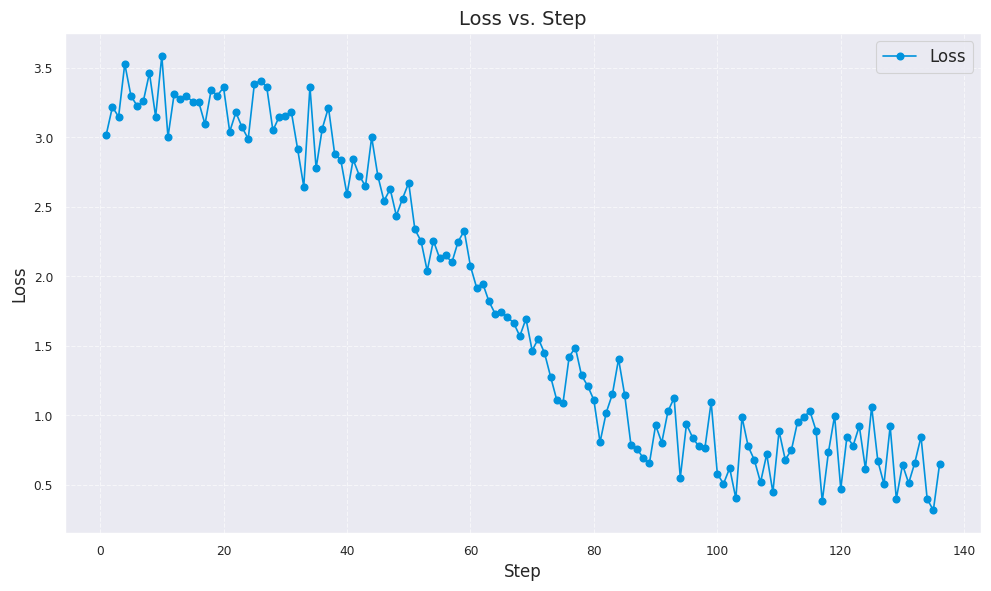

In [28]:
df = pd.DataFrame(trainer.state.log_history)

plt.figure(figsize=(10, 6))
plt.plot(df["step"], df["loss"], marker='o', linestyle='-', color=base_color, label='Loss')
plt.xlabel("Step", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Loss vs. Step", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

<span style="color:red;">**Atenção**</span>: Este é apenas um exemplo de treinamento, o modelo carregado na ceĺula abaixo passou por 18hrs de Fine-Tuning


In [32]:
del model, tokenizer, trainer 
gc.collect()
torch.cuda.empty_cache()

### Execução do Experimento

Será definido novamente todas as variáveis a serem utilizadas.

In [33]:
model_name = "ft_models/Llama-3.1-8B-Instruct-ft-depressionEmo"

# Carregando modelo e Tokenizer com Unsloth
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name,
    device_map="auto",
    token=token
)

# Configurando modelo para inferência.
FastLanguageModel.for_inference(model)

# Configuração de Token
model.generation_config.pad_token_id = tokenizer.pad_token_id

print()


==((====))==  Unsloth 2024.11.7: Fast Llama patching. Transformers = 4.46.3.
   \\   /|    GPU: NVIDIA GeForce RTX 4070. Max memory: 11.623 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.4.1+cu121. CUDA = 8.9. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [34]:
# Redefinição de Prompt e Conteúdo
prompt_template = """
You are an emotion analysis expert tasked with analyzing user posts on a social network. Your goal is to determine which of the emotions below are present in each post, based on its content. For each emotion, ensure you interpret its meaning carefully, identifying both direct and subtle cues that may indicate its presence. Pay attention to the context of the post to avoid misinterpretation, especially in cases where emotions may overlap or be implied.

[LIST OF EMOTIONS]

anger: Expressions of intense frustration, resentment, or hostility, including both overt and subtle expressions of irritation or displeasure.
brain_dysfunction: Mentions of cognitive difficulties, such as memory problems, confusion, or a sense of disorientation. Look for references to unclear thinking or impaired mental functions.
emptiness: Feelings of inner void, lack of purpose, or emotional numbness. This may involve references to "nothingness," a feeling of being "empty," or disconnection from meaning or joy.
hopelessness: A sense of despair, lack of faith in the future, or giving up. It may include statements about losing motivation, a bleak outlook, or a belief that nothing will improve.
loneliness: Perceived isolation, lack of companionship, or disconnection from others. Look for phrases such as "feeling alone" or "no one understands."
sadness: General expressions of sorrow, grief, or melancholy. This can be expressed as sadness over a specific event or a general feeling of sorrow.
suicide_intent: Explicit or implicit references to ending one's life or seeking nonexistence. These may be direct statements about suicide or more subtle hints of a desire to escape life. Please use extreme caution when identifying this emotion.
worthlessness: Feelings of being unimportant, inadequate, or having no value. This can include self-deprecating language or thoughts about being a failure or not measuring up to expectations.

[OUTPUT FORMAT]
Return only a list in array format containing the identified emotions, separated by commas. Multiple emotions may be identified for a single post.

[EXAMPLES]
{examples}

[END OF EXAMPLES]

[INPUT DATA]
Now, analyze the text below carefully and return the emotions in the required format.
Input:
Post Title: {title}
Post Content: {content}
[END OF INPUT DATA]

[OUTPUT]
"""

# Prompt para Exemplo
example_template = """
Post Title: {title}
Post Content: {content}
Output:
{emotions}
"""

for i in range(len(posts_examples)):
    posts_examples[i]['example'] = example_template. \
        format(
            title=posts_examples[i]['title'], 
            content = posts_examples[i]['post'], 
            emotions = posts_examples[i]['emotions']
        )

# Criação dos Embeddings
embeddings = HuggingFaceEmbeddings(model_name="paraphrase-mpnet-base-v2")

# Criação dos exemplos 
example_selector = SemanticSimilarityExampleSelector.from_examples(
    # Base de Exemplos
    posts_examples,   
    # Embeddings
    embeddings, 
    # Dabase de Embeddings
    FAISS,
    # Número de exemplos a ser retornado
    k=2,
    # Chave de Entrada
    input_keys=["example"],
)

In [35]:
# Array para armazenar os resultados
results = []

# Lista de emoçẽos possíveis
emotions = ['anger', 'brain_dysfunction', 'emptiness', 'hopelessness', 'loneliness', 'sadness', 'suicide_intent', 'worthlessness']


# Para cada Post
for post in tqdm(posts, desc='Inferindo'):

    # Limpa VRAM e força o Garbage Collector
    torch.cuda.empty_cache()
    gc.collect()

    # Criação do Exemplo de formato 
    ex_prompt = example_template.format(title=post['title'], content = post['post'], emotions = '')

    # Seleção de examplos 
    res = example_selector.select_examples({"example": ex_prompt})
    s = ''

    # Concatenação de examplos 
    for item in res:
        s = s + '\n# Example\nInput:' + example_template.format(title=item['title'], content = item['post'], emotions = item['emotions'])
    
    # Criação do prompt
    prompt = prompt_template.format(examples= s, title = post['title'], content=post['post'])

    # Transformando em Template de Chat
    messages = [
        {"role": "user", "content": prompt}
    ]

    # Gerando tokenização
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    # Enviando dados para a GPU
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

    # Gerando Resposta
    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=64,
        pad_token_id=tokenizer.eos_token_id
    )

    # Transformando resposta
    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    # Convertendo de Tokens para Texto
    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    # Tratamento Manual - Tratamento de emoções e remoção de texto desnecessário
    validate_response = response \
        .replace('angry', 'anger') \
        .split('\n')[0]
    
    try:
        # Tentativa de Conversão em Array e Armazenamento de processamento
        results.append({
            'id': post['id'],
            'esperado': post['emotions'],
            'realizado': [item for item in ast.literal_eval(validate_response) if item in emotions],
            'original': ast.literal_eval(validate_response)

        })
    except Exception as e:
        # Caso de Erro
        print('Error', e)
        print(response)
        continue

Inferindo: 100%|██████████████████████████████| 906/906 [12:59<00:00,  1.16it/s]


In [36]:
results = pd.DataFrame(results)

results.head(5)

,id,esperado,realizado,original
0,w83pst,"[hopelessness, sadness]","[sadness, hopelessness, emptiness, worthlessness]","[sadness, hopelessness, emptiness, worthlessness]"
1,f2234m,"[hopelessness, sadness]","[sadness, hopelessness, worthlessness, lonelin...","[sadness, hopelessness, worthlessness, lonelin..."
2,17d3zn2,"[worthlessness, hopelessness, emptiness, sadne...","[worthlessness, hopelessness, emptiness, sadness]","[worthlessness, hopelessness, emptiness, sadness]"
3,fn48mt,"[hopelessness, sadness, worthlessness, lonelin...","[hopelessness, emptiness, worthlessness, lonel...","[hopelessness, emptiness, worthlessness, lonel..."
4,11w2im7,[loneliness],"[loneliness, emptiness, anger]","[loneliness, emptiness, anger]"


---

### Mensuração dos Resultados

Para a mensuração, será analisado o F-Score e o Hamming Loss.

Para o F-Score, quanto mais próximo de 1 o valor, melhor será o resultado. Já para o Hamming Loss,quanto mais próximo de 0, melhor o resultado atingido. 

Porém, antes da mensuração, será necessário binarizar os resultados obtidos.

In [37]:
true_y = results[['esperado']]
true_y = pd.get_dummies(true_y.explode('esperado')).groupby(level=0).sum()
cols = sorted(true_y.columns.values)
true_y = true_y[cols]
y_true = true_y.to_numpy()

predict_y = results[['realizado']]
predict_y = pd.get_dummies(predict_y.explode('realizado')).groupby(level=0).sum()
cols = sorted(predict_y.columns.values)
predict_y = predict_y[cols]
predict_y[predict_y > 1] = 1
y_pred = predict_y.to_numpy()

print('F1-Score:', f1_score(y_true=y_true, y_pred=y_pred, average='micro'))
print('Hamming Loss:', hamming_loss(y_true=y_true, y_pred=y_pred))

F1-Score: 0.7141083988415391
Hamming Loss: 0.2860099337748344


O processo de **Fine-Tuning** resultou em um incremento de cerca de **1,5% no F1-Score**, trazendo maior confiabilidade aos resultados obtidos pelo modelo.  

O **Hamming Loss** também apresentou uma redução discreta, indicando uma melhoria na precisão geral das previsões.  

É importante destacar que foi utilizado o modelo com **8 bilhões de parâmetros**, executado em recursos locais. O uso de modelos maiores, como os de **14 bilhões** ou **70 bilhões de parâmetros**, pode potencialmente fornecer resultados ainda mais consistentes, devido à sua capacidade de capturar representações mais complexas.  

Ao comparar os resultados obtidos inicialmente, sem a aplicação do **Dynamic Few-Shot Learning** e do **Fine-Tuning**, houve uma melhoria de aproximadamente **10% no F1-Score**, reafirmando a eficácia dessas técnicas.  

Os resultados deste estudo sugerem a viabilidade do uso de **LLMs** para tarefas de **classificação multirrótulo** em dados não estruturados, destacando seu potencial para resolver problemas complexos de forma eficiente.  